# Top Music Predictor
___

Dataset: https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023

## Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import VotingClassifier

sb.set()

## Data Extraction, Cleaning, Processing and Spliting

Extracting the data from spotify-2023.csv

In [4]:
music_data = pd.read_csv('spotify-2023.csv', encoding='ISO-8859-1')

Displaying the unclean and unprocessed data

In [5]:
music_data

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,The Great War,Taylor Swift,1,2022,10,21,1274,0,181382590,1,...,96,F,Major,57,55,74,22,0,8,4
948,My Mind & Me,Selena Gomez,1,2022,11,3,953,0,91473363,61,...,144,A,Major,60,24,39,57,0,8,3
949,Bigger Than The Whole Sky,Taylor Swift,1,2022,10,21,1180,0,121871870,4,...,166,F#,Major,42,7,24,83,1,12,6
950,A Veces (feat. Feid),"Feid, Paulo Londra",2,2022,11,3,573,0,73513683,2,...,92,C#,Major,80,81,67,4,0,8,6


Cleaning the data to only have the required Features

In [6]:
required_features = ["track_name", "streams", "danceability_%", "valence_%", "energy_%", "acousticness_%", "instrumentalness_%", "speechiness_%"]

music_data_processed = music_data[required_features]

music_data_processed = music_data_processed.drop_duplicates(subset=['track_name']).reset_index(drop=True)

music_data_processed['streams'] = pd.to_numeric(music_data_processed['streams'], errors='coerce').fillna(0).astype(np.int64)

Processing the data to classify boundries based on streams

In [7]:
# Define the class boundaries based on streams
def categorize_popularity(row):
    max_streams = music_data_processed['streams'].max()
    if row['streams'] < np.percentile(music_data_processed['streams'].dropna(), 33): 
        return 0  # Low popularity
    elif np.percentile(music_data_processed['streams'].dropna(), 33) <= row['streams'] <= np.percentile(music_data_processed['streams'].dropna(), 66):
        return 1  # Moderate popularity
    else:
        return 2  # High popularity

# Apply the function to create a 'popularity_class' column
music_data_processed['popularity_class'] = music_data_processed.apply(categorize_popularity, axis=1)

music_data_processed

,track_name,streams,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,speechiness_%,popularity_class
0,Seven (feat. Latto) (Explicit Ver.),141381703,80,89,83,31,0,4,0
1,LALA,133716286,71,61,74,7,0,4,0
2,vampire,140003974,51,32,53,17,0,6,0
3,Cruel Summer,800840817,55,58,72,11,0,15,2
4,WHERE SHE GOES,303236322,65,23,80,14,63,6,1
...,...,...,...,...,...,...,...,...,...
937,The Great War,181382590,57,55,74,22,0,4,1
938,My Mind & Me,91473363,60,24,39,57,0,3,0
939,Bigger Than The Whole Sky,121871870,42,7,24,83,1,6,0
940,A Veces (feat. Feid),73513683,80,81,67,4,0,6,0


Splitting the data to test and train

In [8]:
# Features and target variable
feature_cols = ["danceability_%", "valence_%", "energy_%", "acousticness_%", "instrumentalness_%", "speechiness_%"]

X = music_data_processed[feature_cols]
y = music_data_processed['popularity_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Visualisation

Creating a Custom Pallete for a unique visualisation

In [9]:
custom_palette = sb.cubehelix_palette(start=1.6, rot=0.9, light=0.7, dark=0.3, n_colors=3)

Feature Correlation Heatmap to show the relationship between all the features

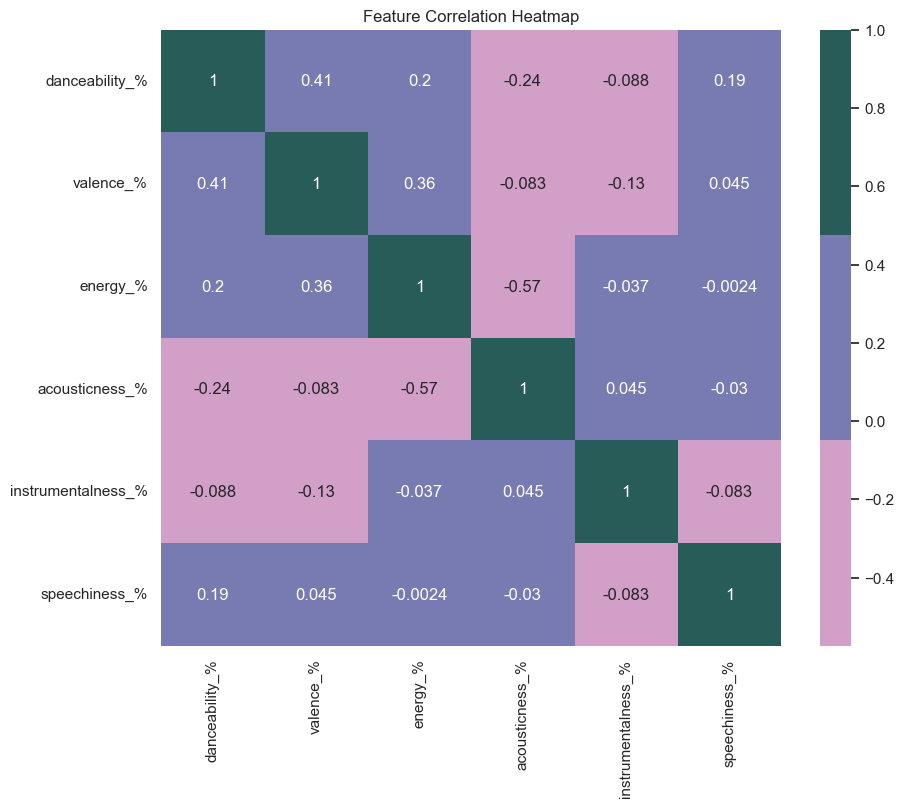

In [10]:
plt.figure(figsize=(10, 8))
sb.heatmap(X.corr(), annot=True, cmap=custom_palette)
plt.title('Feature Correlation Heatmap')
plt.show()

Showing the pairplot for the features

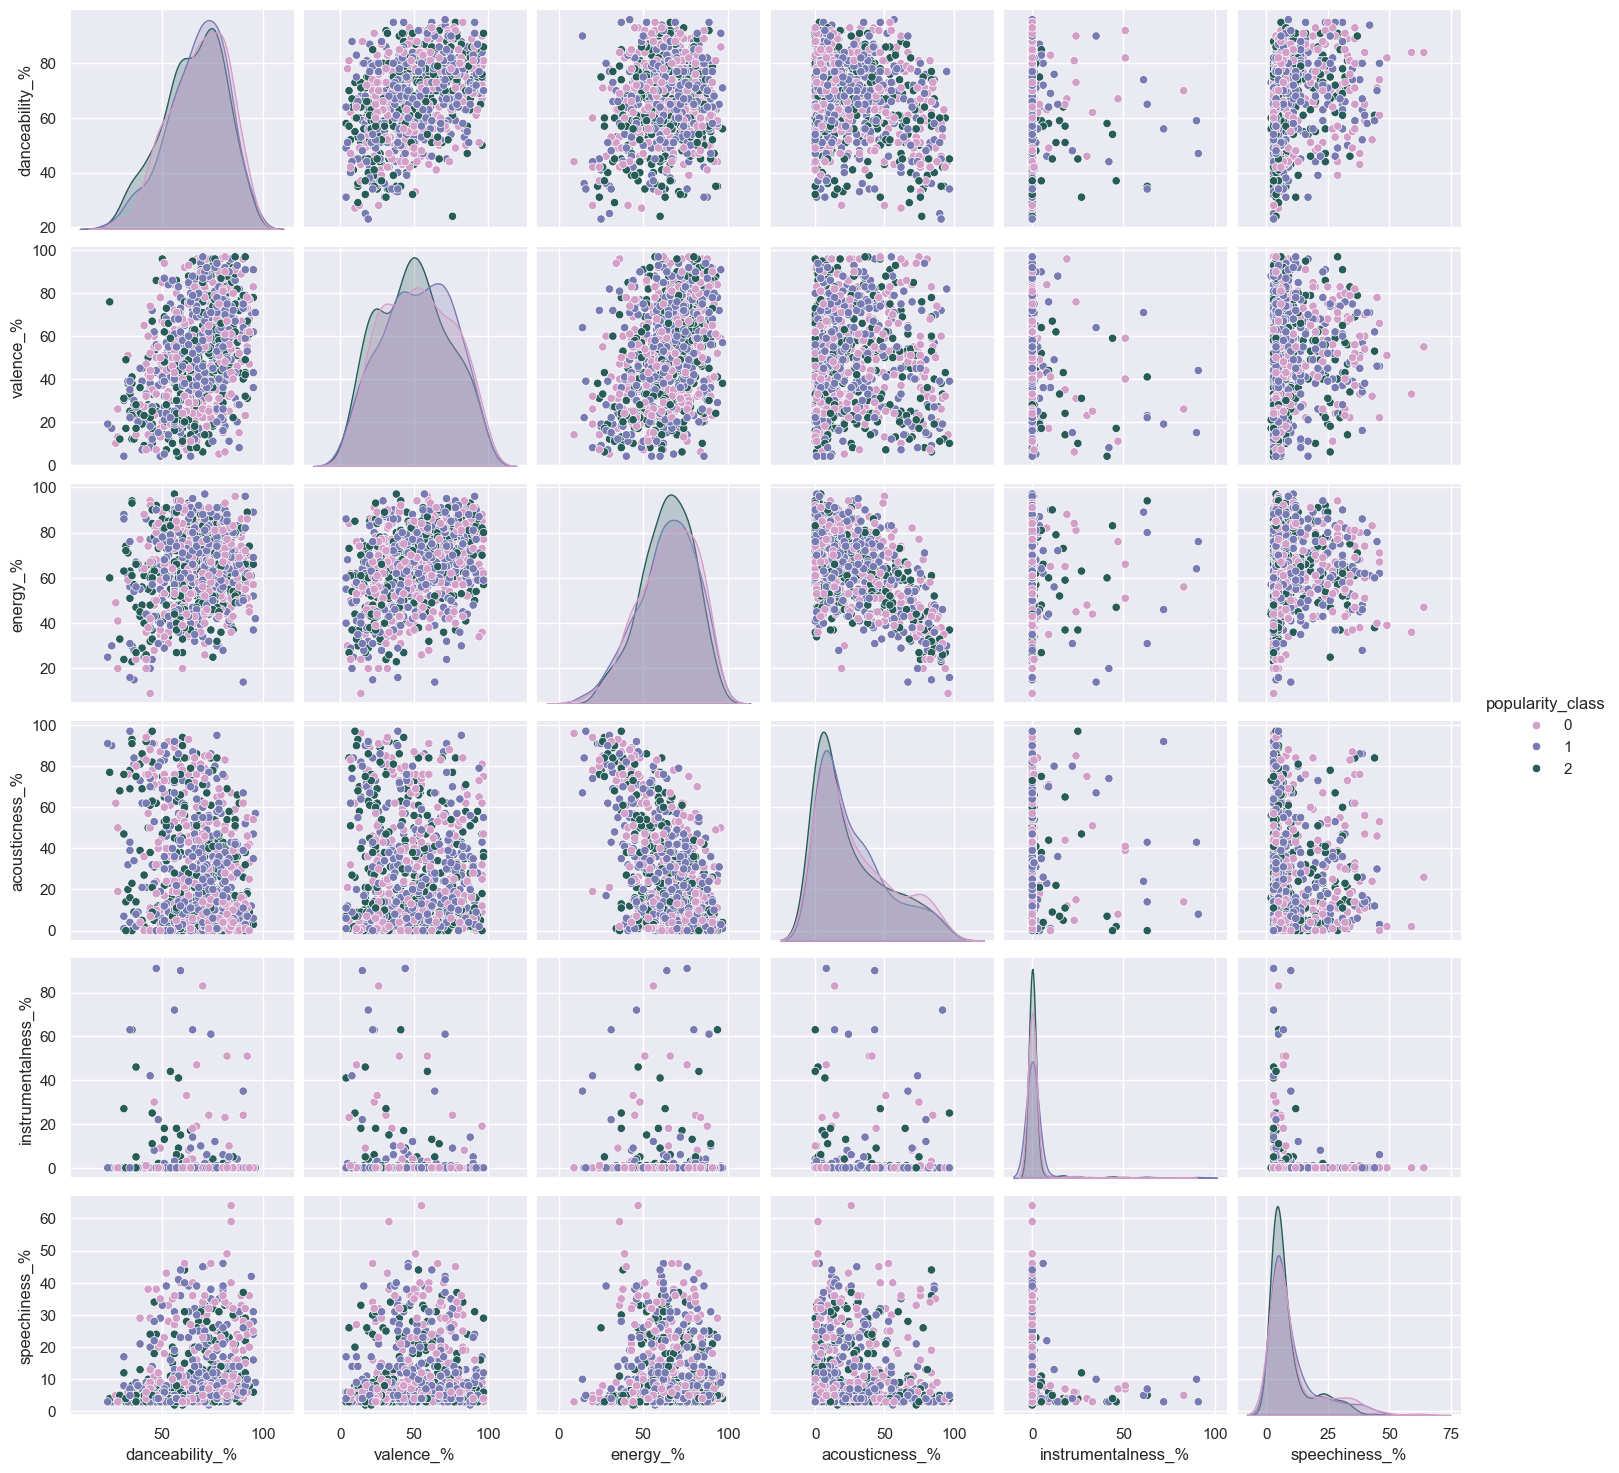

In [11]:
sb.pairplot(music_data_processed, hue='popularity_class', vars=required_features[2:], palette=custom_palette)
plt.show()

Displaying the distribution of the songs based on the popularity_class for EACH feature

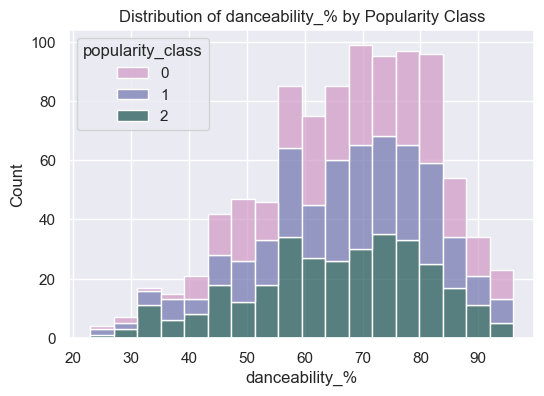

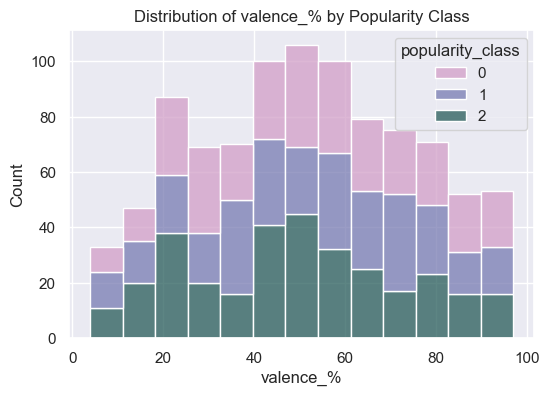

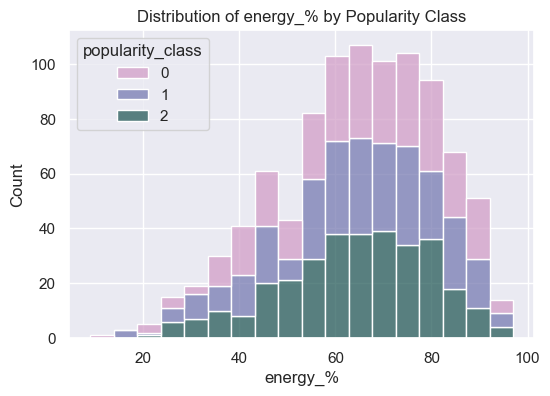

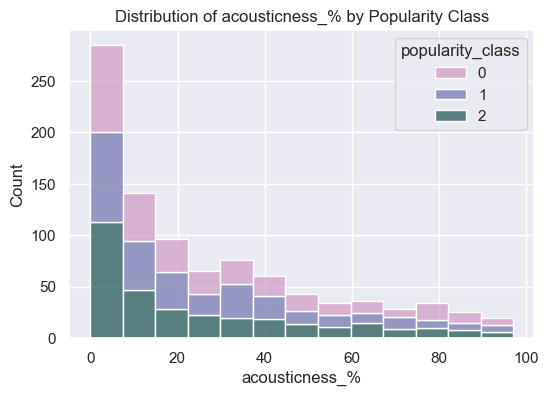

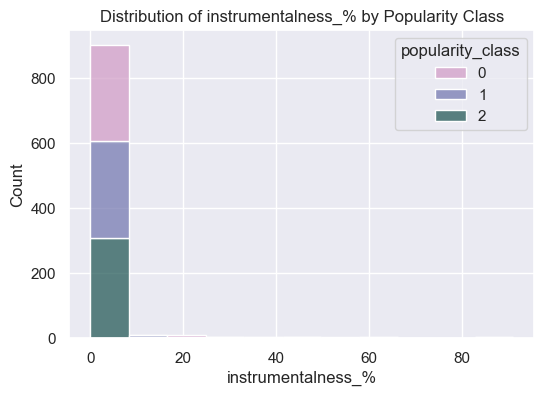

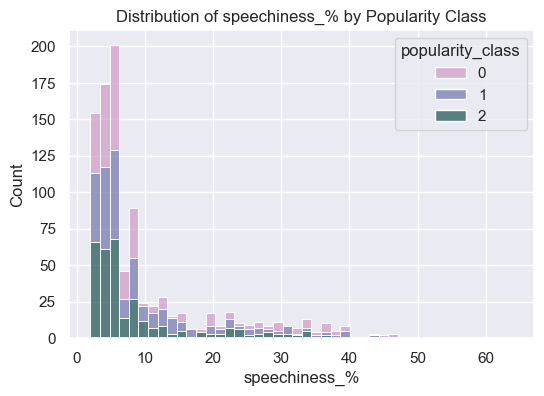

In [12]:
for col in required_features[2:]:
    plt.figure(figsize=(6, 4))
    sb.histplot(data=music_data_processed, x=col, hue="popularity_class", multiple="stack", palette=custom_palette)
    plt.title(f'Distribution of {col} by Popularity Class')
    plt.show()

## Models for Prediction

#### K Nearest Neighbour

Creating and Training the Model

In [13]:
# scale data since we're working with KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#finding the optimal k value for the KNN Model
knn_accuracies = {}
for k in range(1, 31):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    knn_accuracies[k] = acc

best_k = max(knn_accuracies, key=knn_accuracies.get)
print(f"Best KNN accuracy: {knn_accuracies[best_k]:.3f} at k={best_k}")

# Final KNN model with the best k value
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_train)
y_pred_knn = knn_best.predict(X_test_scaled)
print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

Best KNN accuracy: 0.432 at k=6

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.48      0.44        77
           1       0.43      0.32      0.36        79
           2       0.47      0.50      0.48        80

    accuracy                           0.43       236
   macro avg       0.43      0.43      0.43       236
weighted avg       0.43      0.43      0.43       236



Evaluating the Accuracy of the model

In [14]:
# Evaluating the accuracy of the KNN model
print("Accuracy: ", accuracy_score(y_test, y_pred_knn))
print("Classification Report: \n", classification_report(y_test, y_pred_knn))

Accuracy:  0.4322033898305085
Classification Report: 
               precision    recall  f1-score   support

           0       0.40      0.48      0.44        77
           1       0.43      0.32      0.36        79
           2       0.47      0.50      0.48        80

    accuracy                           0.43       236
   macro avg       0.43      0.43      0.43       236
weighted avg       0.43      0.43      0.43       236



Visualisation of the model to show feature importance

/var/folders/0g/q6wgl76d3w3dkd4l5yhyfg440000gn/T/ipykernel_79866/1630730781.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x='Importance', y='Feature', data=KNN_feature_importance, palette=custom_palette)
/var/folders/0g/q6wgl76d3w3dkd4l5yhyfg440000gn/T/ipykernel_79866/1630730781.py:11: UserWarning: 
The palette list has fewer values (3) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sb.barplot(x='Importance', y='Feature', data=KNN_feature_importance, palette=custom_palette)


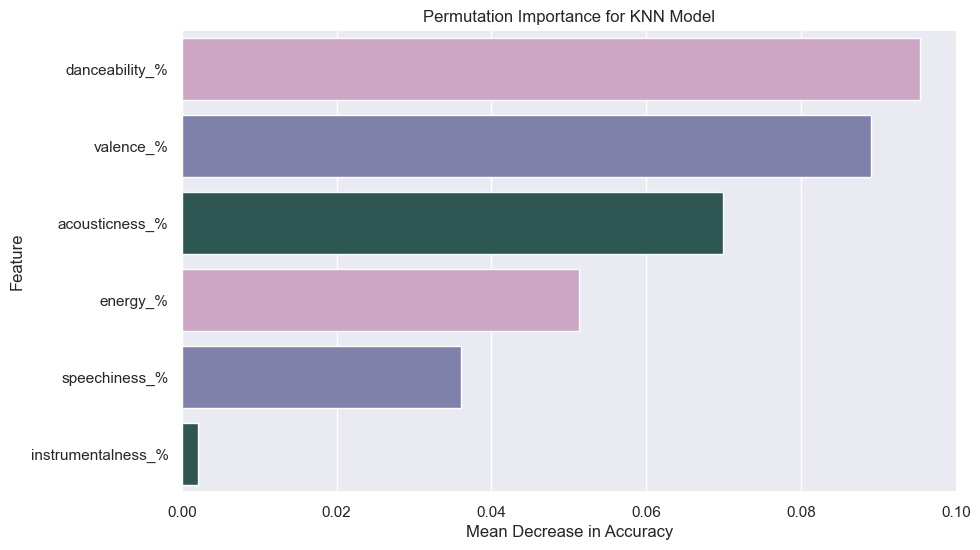

In [15]:
# Calculate permutation importance
result = permutation_importance(knn_best, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Plotting feature importance
KNN_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sb.barplot(x='Importance', y='Feature', data=KNN_feature_importance, palette=custom_palette)
plt.title('Permutation Importance for KNN Model')
plt.xlabel('Mean Decrease in Accuracy')
plt.show()

#### Random Forest Classifier

Creating and Training the Model

In [14]:
# --- Random Forest with Grid Search ---
rfc = RandomForestClassifier(random_state=42)
rfc_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

rfc_grid = GridSearchCV(rfc, rfc_params, cv=5, scoring='accuracy')
rfc_grid.fit(X_train_scaled, y_train)
rfc_best = rfc_grid.best_estimator_
y_pred_rfc = rfc_best.predict(X_test_scaled)

Evaluating the Accuracy of the Model

In [15]:
# Evaluate the model
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rfc))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.43      0.42        77
           1       0.33      0.28      0.30        79
           2       0.43      0.47      0.45        80

    accuracy                           0.39       236
   macro avg       0.39      0.39      0.39       236
weighted avg       0.39      0.39      0.39       236



Visualisation of the model to show feature importance

/var/folders/0g/q6wgl76d3w3dkd4l5yhyfg440000gn/T/ipykernel_79778/766748880.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x='Importance', y='Feature', data=RFC_feature_importance, palette=custom_palette)
/var/folders/0g/q6wgl76d3w3dkd4l5yhyfg440000gn/T/ipykernel_79778/766748880.py:12: UserWarning: 
The palette list has fewer values (3) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sb.barplot(x='Importance', y='Feature', data=RFC_feature_importance, palette=custom_palette)


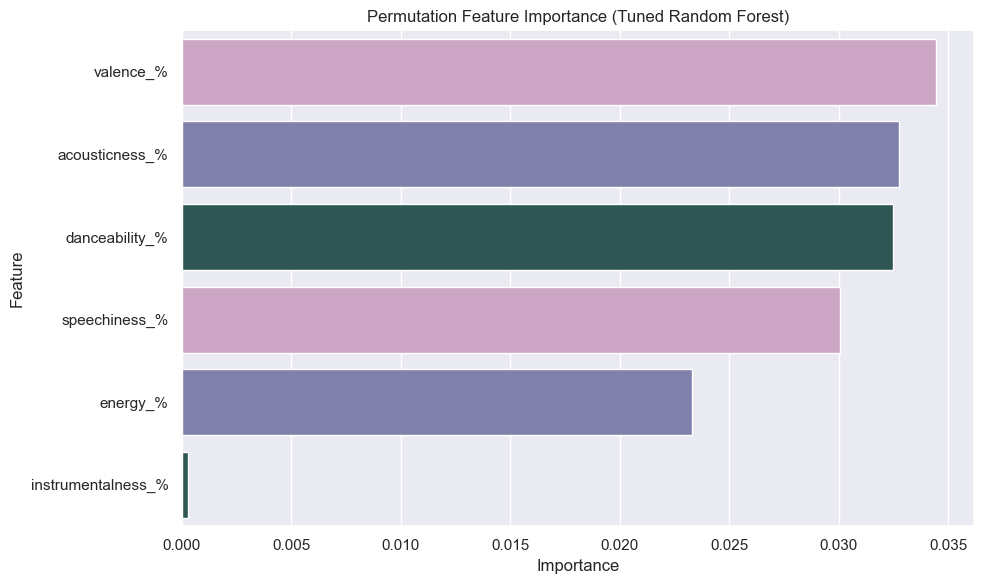

In [16]:
# Compute permutation importance on the test set
rfc_perm = permutation_importance(rfc_best, X_test_scaled, y_test, n_repeats=30, random_state=42, n_jobs=-1)

# Create DataFrame of feature importances
RFC_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rfc_perm.importances_mean,
}).sort_values(by='Importance', ascending=False)

# Plot the importances
plt.figure(figsize=(10, 6))
sb.barplot(x='Importance', y='Feature', data=RFC_feature_importance, palette=custom_palette)
plt.title('Permutation Feature Importance (Tuned Random Forest)')
plt.tight_layout()
plt.show()

#### Ensemble Model (KNN + RFC) using a Voting Classifier

Creating and Training the Model

In [17]:
# --- Ensemble Model (KNN + RFC) ---
ensemble = VotingClassifier(estimators=[
    ('knn', knn_best),
    ('rfc', rfc_best)
], voting='soft')

ensemble.fit(X_train_scaled, y_train)
y_pred_ensemble = ensemble.predict(X_test_scaled)

Viewing the Accuracy

In [18]:
print("\nEnsemble Classification Report:")
print(classification_report(y_test, y_pred_ensemble))


Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.38      0.40        77
           1       0.42      0.35      0.38        79
           2       0.45      0.56      0.50        80

    accuracy                           0.43       236
   macro avg       0.43      0.43      0.43       236
weighted avg       0.43      0.43      0.43       236



Visualisation of the model to show feature importance

/var/folders/0g/q6wgl76d3w3dkd4l5yhyfg440000gn/T/ipykernel_79778/4273977888.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x='Importance', y='Feature', data=feature_importance_df, palette=custom_palette)
/var/folders/0g/q6wgl76d3w3dkd4l5yhyfg440000gn/T/ipykernel_79778/4273977888.py:13: UserWarning: 
The palette list has fewer values (3) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sb.barplot(x='Importance', y='Feature', data=feature_importance_df, palette=custom_palette)


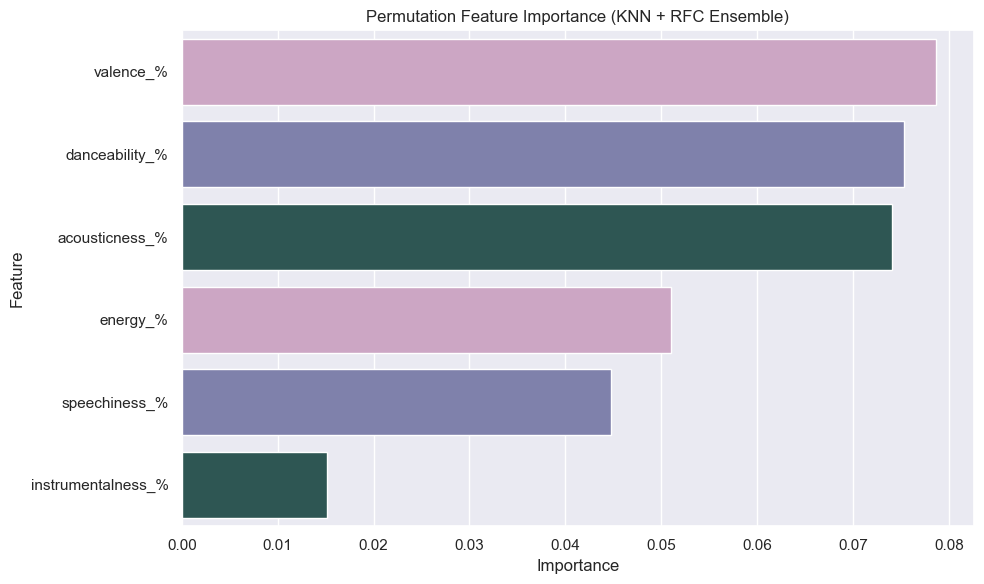

In [19]:
# Compute permutation importance
ensemble_perm = permutation_importance(ensemble, X_test_scaled, y_test, n_repeats=30, random_state=42, n_jobs=-1)

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': ensemble_perm.importances_mean,
    'Importance Std': ensemble_perm.importances_std
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sb.barplot(x='Importance', y='Feature', data=feature_importance_df, palette=custom_palette)
plt.title('Permutation Feature Importance (KNN + RFC Ensemble)')
plt.tight_layout()
plt.show()

## Output final product

Input a song's features to check if it is a hit or not

In [ ]:
def predict_popularity_category():
    print("Enter the features of the song:")
    
    # Input features from the user
    danceability = float(input("Danceability (%): "))
    valence = float(input("Valence (%): "))
    energy = float(input("Energy (%): "))
    acousticness = float(input("Acousticness (%): "))
    instrumentalness = float(input("Instrumentalness (%): "))
    speechiness = float(input("Speechiness (%): "))
    
    # Create a DataFrame for the new song
    new_song = {
        'danceability_%': danceability,
        'valence_%': valence,
        'energy_%': energy,
        'acousticness_%': acousticness,
        'instrumentalness_%': instrumentalness,
        'speechiness_%': speechiness
    }
    new_song_df = pd.DataFrame([new_song])
    
    # Predict the popularity class for the new song
    popularity_class_KNN = knn_best.predict(new_song_df)[0]
    popularity_class_RFC = rfc_best.predict(new_song_df)[0]
    popularity_class_ensemble = ensemble.predict(new_song_df)[0]
    # Map the class to a label

    category_labels = ['Low popularity', 'Moderate popularity', 'High popularity', 'Very high popularity']
    print(f"\nPredicted popularity category (in the KNN Model): {category_labels[popularity_class_KNN]}")
    print(f"\nPredicted popularity category (in the RFC Model): {category_labels[popularity_class_RFC]}")
    print(f"\nPredicted popularity category (in the Ensemble Model): {category_labels[popularity_class_ensemble]}")

# Call the function to interact with the user
predict_popularity_category()

Enter the features of the song:
